<a href="https://colab.research.google.com/github/ruhanaazam/gp_transfer/blob/main/sdd_coh2_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install gpytorch
!pip install botorch

In [3]:
!cd drive

In [4]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import gpytorch
from botorch.utils.transforms import normalize, standardize
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def surfacePlot(model, title = "Your Function" ,n=900):
    '''
    Plots your (true or estimated) coheritability function.
    model: function that takes in two wavelength and outputs coh2 (estimate)
    n: n**2 is the number of points to plot the surface
    '''
    # Generate data for the plot
    x1 = torch.linspace(0, 1, n)
    x2 = torch.linspace(0, 1, n)
    X1, X2 = torch.meshgrid(x1, x2)
    X = torch.stack([X1.reshape((-1)),X2.reshape((-1))]).T

    Z = model(X.to(device))#.cpu().detach().numpy()

    # Create a contour plot
    plt.contourf(X1, X2, Z.reshape(n, n), cmap='viridis')
    plt.colorbar(label='Function Value')

    #plot top 1%
    #threshold = np.percentile(Z, 99)
    #threshold = torch.kthvalue(Z.flatten(), int(0.99 * n * n)).values
    #plt.contour(X1, X2, Z.reshape(n, n), levels=[threshold], colors='red', linewidths=2)

    # Add labels and title
    plt.xlabel('Wavelength 1')
    plt.ylabel('Wavelength 2')
    plt.title(title)

    # Show the plot
    plt.show()
    return

In [6]:
def getTaskID(trait, crop="Sorghum"):
    assert crop == "Sorghum", "Does not handles ids for from that are not Sorghum yet."
    ids = {"narea": 1, "sla": 2, "pn": 3, "ps": 4}
    return ids[trait]

In [7]:
def loadTasks(tasks):
    taskData = []
    for trait in tasks:
        #read raw task file
        data = pd.read_csv(f"/content/drive/My Drive/Colab Notebooks/Transfer_Coh2/data/{trait}_coh2.csv")
        data = torch.tensor(data.values)

        #format data for supervised training, each row (taskid, wave1, wave2, coh2)
        n = torch.ones(data.shape[0], dtype=torch.float32)
        col_index =  torch.arange(data.shape[0], dtype=torch.float32)
        col_index = torch.outer(n, col_index)
        row_index = col_index.T

        #stack wave1, wave2 and coh2 tensors together
        task_ids = torch.ones(data.shape) * getTaskID(trait)
        flat_data = torch.stack([task_ids.flatten(), col_index.flatten(), row_index.flatten(), data.flatten()])
        flat_data = flat_data.T

        #remove all rows with nans
        nan_mask = torch.isnan(flat_data)
        nan_in_rows = torch.any(nan_mask, dim=1)
        clean = flat_data[~nan_in_rows]

        taskData.append(clean)

    #combine all tasks
    all_tasks = torch.cat(taskData)
    return all_tasks[:, :3], all_tasks[:, -1]

In [8]:
#Load data (by tasks)
X, Y = loadTasks(["narea"])

#Split into train and validation sets
seed = 1234
split = 1
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=split, random_state=seed)

# Convert NumPy arrays to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float64)
y_train = torch.tensor(y_train, dtype=torch.float64)
x_test = torch.tensor(x_test, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64)

# # Create TensorDatasets
# train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
# test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

# # Create DataLoader for training and test sets
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

<ipython-input-8-80e7c077d3fd>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float64)
<ipython-input-8-80e7c077d3fd>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float64)
<ipython-input-8-80e7c077d3fd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float64)
<ipython-input-8-80e7c077d3fd>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

In [9]:
# #x points for plot
# space_x = np.linspace(350, 2500, 500)
# mesh_x, mesh_y = np.meshgrid(space_x, space_x)
# x_pred = np.vstack([mesh_x.ravel(), mesh_y.ravel()]).T

In [10]:
#subsection of data
N = 3000

#todo: change to mixed dataset
x_train = x_train[:N, 1:] #remove task feature
x_train = normalize(x_train, torch.tensor([[0,0],[2150,2150]])).numpy()
y_train = y_train [:N]
y_train = standardize(y_train).numpy()

#define kernel(s) for dataset above
kernel = gpytorch.kernels.RBFKernel(ard_num_dims=2) #todo: change this to mixed kernel
kernel.lengthscale = torch.tensor([0.03, 0.035])

rbf = kernel.__call__
def k(x, y, h=rbf):
  x = torch.tensor(x, dtype=torch.float64)
  y = torch.tensor(y, dtype=torch.float64)
  return h(x, y).numpy()

In [11]:
noise_scale = 0.04

#solve (exact) kernel regression
K = k(x_train, x_train, rbf)
alpha_exact = np.linalg.solve(K + noise_scale ** 2 * np.eye(N), y_train)

def exactMean(x_pred):
  return k(x_pred, x_train) @ alpha_exact

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-10-85f5d26e5fb9>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float64)


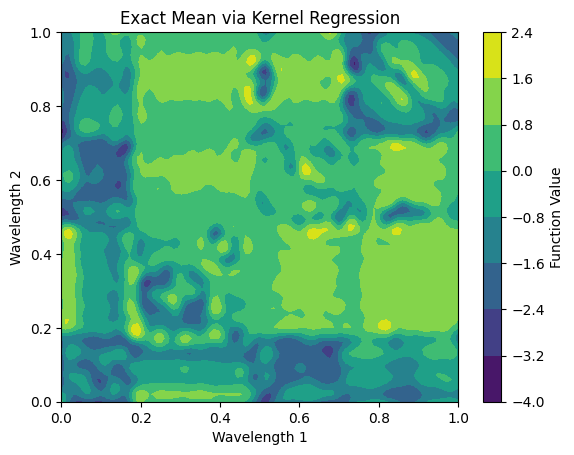

In [12]:
surfacePlot(exactMean, title="Exact Mean via Kernel Regression", n=100)

Using SDD method (refer: https://anonymous.4open.science/r/sdd-gps-5486/sdd.ipynb
)

In [13]:
lr = 0.0001
momentum = 0.9
polyak = 1e-2
iterations = 3500
B = 10

#intialize variables
alpha = np.zeros((N,))
alpha_polyak = np.zeros((N,))
v = np.zeros((N,))


#dual objective
def g(params, idx, k, N, B, noise_scale):
    K_batch = k(x_train[idx], x_train)
    grad = np.zeros((N,))
    grad[idx] = K_batch @ params - y_train[idx] + (noise_scale ** 2) * params[idx]
    return (N / B) * grad

#update parameter
def update(params_polyak, velocity, params, idx, k,  N, B, noise_scale):
    grad = g(params=params, idx=idx, k=k, N=N, B=B, noise_scale=noise_scale)
    velocity = momentum * velocity - lr * grad
    params = params + velocity
    params_polyak = polyak * params + (1.0 - polyak) * params_polyak
    return params, params_polyak, velocity

In [14]:
for i in range(iterations):
    idx = np.random.choice(N, size=(B,), replace=False)
    alpha, alpha_polyak, v = update(params_polyak=alpha_polyak,
                                    velocity=v,
                                    params=alpha,
                                    idx=idx, k=k, N=N, B=B,noise_scale=noise_scale)

In [15]:
def sddMean(x_pred):
  return k(x_pred, x_train) @ alpha_polyak

<ipython-input-10-85f5d26e5fb9>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float64)


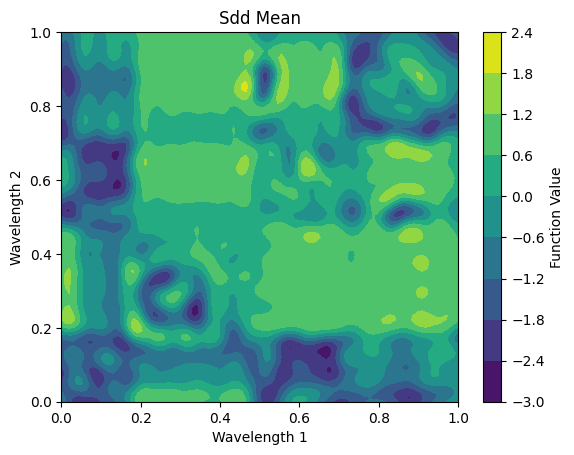

In [16]:
surfacePlot(sddMean, title="Sdd Mean", n=100)